# PetroKit — Cuaderno Técnico de Análisis Nodal

**Cuaderno técnico, reproducible y auditable** para análisis nodal, diseñado para revisión de ingeniería, verificación de modelos y demostración de las capacidades actuales del paquete **PetroKit**.

Este cuaderno contiene:

* Explicación rigurosa de la física utilizada en los modelos **monofásicos y multifásicos** implementados.
* Inclusión de modelos avanzados de IPR (Standing, Jones) y VLP robustos (Beggs & Brill, Hagedorn & Brown).
* Generación de tablas PVT tipo Black-Oil.
* Tablas de parámetros detalladas y convenciones de unidades claramente documentadas.
* Bloques de código verificados que llaman exclusivamente a los módulos oficiales de `petrokit` (IPR, VLP, Flowline, Nodal, PVT).
* Estudios de sensibilidad, manejo de errores y verificación de casos límite.
* Exportación de resultados y figuras reproducibles para informes técnicos.

Utilice este cuaderno como un **entregable técnico de ingeniería** para acompañar el paquete PetroKit, o como material de referencia para validación, auditoría y extensión de los modelos implementados.

---

## Tabla de contenido

1. [Supuestos y sistema de unidades]
2. [Fundamentos físicos y ecuaciones]
3. [Generación de Tablas PVT]
4. [Validaciones rápidas y funciones de apoyo]
5. [Validación y gráficos de la IPR (Modelos Avanzados)]
6. [Validación y gráficos de la VLP (Tubería)]
7. [Análisis nodal — intersección y búsqueda del punto de operación]
8. [Estudios de sensibilidad y barridos paramétricos]

---

## 1. Supuestos y sistema de unidades {#supuestos}

**Convención de unidades usada en este cuaderno**:

* Presión: **psi / psia**.
* Caudal: **STB/día** (líquido) y **MSCF/día** (gas).
* Longitud: **ft**.
* Diámetro: **in**.
* Densidad: **lb/ft³**.
* Viscosidad: **cP**.
* Temperatura: **°F / °R**.

---

## 2. Fundamentos físicos y ecuaciones {#physics}

### IPR — Modelos

#### Vogel
$$ q = q_{max} \ ( 1 - 0.2 
rac{p_{wf}}{p_{res}} - 0.8 \ (
rac{p_{wf}}{p_{res}}
ight)^2 
ight) $$

#### Standing (Fase 2)
Utilizado para reservorios con gas en solución:
$$ q = q_{max} \ ( 1 - \ (
rac{p_{wf}}{p_{res}}
ight)^n 
ight) $$

#### Jones (Fase 2)
Para pozos con efectos de daño (skin):
$$ q = rac{J}{1+s} (p_{res} - p_{wf}) $$

### Correlaciones VLP (Fase 2)
*   **Beggs & Brill:** Correlación integral que maneja flujo vertical, inclinado y horizontal, determinando el régimen de flujo y el *holdup* líquido.
*   **Hagedorn & Brown:** Especialmente diseñada para flujo vertical, utilizando parámetros empíricos para el cálculo de la densidad mixta y la caída de presión.

### PVT - Black Oil
*   **Standing (1947):** Correlaciones para $Rs$ y $Bo$.
*   **Sutton (1985):** Propiedades pseudo-críticas del gas.
*   **Papay:** Factor $Z$ explícito.

In [1]:
# Importaciones y configuración por defecto para gráficos
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Ajustes básicos de visualización
plt.rcParams.update({"figure.dpi": 120, "font.size": 10})

try:
    from petrokit.pvt import build_pvt_table
    from petrokit.ipr_advanced import standing_ipr, jones_ipr, plot_standing_sensitivity, plot_jones_sensitivity
    from petrokit.vlp_advanced import beggs_brill_dp, hagedorn_brown_dp
    from petrokit.flowline import flowline_pressure_drop
    from petrokit.nodal import nodal_analysis
    from petrokit.ipr import vogel_ipr
    import petrokit.utils as utils

    _PETROKIT_AVAILABLE = True
except ImportError as e:
    _PETROKIT_AVAILABLE = False
    print(f"Advertencia de importación: {e}")

## 3. Generación de Tablas PVT

Antes de proceder con el análisis de flujo, es crucial contar con las propiedades del fluido. PetroKit permite generar tablas Black-Oil a partir de parámetros básicos.

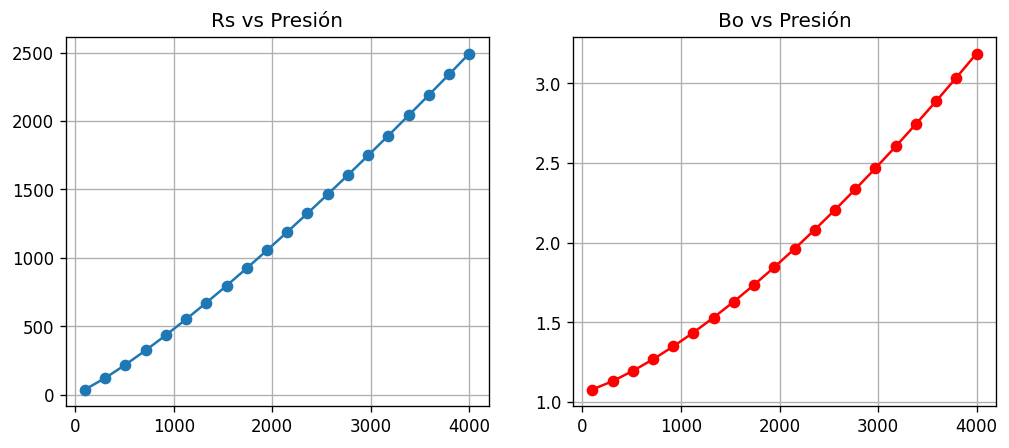

In [2]:
# Parámetros para la tabla PVT
pressures = np.linspace(100, 4000, 20)
temp = 180 # °F
api = 30
gamma_g = 0.65

pvt_data = build_pvt_table(pressures, temp, api, gamma_g)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(pvt_data['P_psia'], pvt_data['Rs_scf_stb'], 'o-')
plt.title("Rs vs Presión")
plt.grid(True)
plt.subplot(1, 2, 2)
plt.plot(pvt_data['P_psia'], pvt_data['Bo_rb_stb'], 'r-o')
plt.title("Bo vs Presión")
plt.grid(True)
plt.show()

#### 4. Validaciones rápidas y funciones de apoyo

Estandarizamos las validaciones para asegurar que los modelos avanzados operen en rangos físicos correctos.

In [4]:
def validate_positive(name, value, allow_zero: bool = False):
    """
    Valida positividad física básica.
    - allow_zero=True se usa para caudales/rangos donde 0 es válido.
    """
    if value is None:
        raise ValueError(f"{name} es requerido")

    arr = np.asarray(value) if isinstance(value, (list, tuple, np.ndarray)) else None
    if arr is not None:
        if allow_zero:
            bad = np.any(arr < 0)
        else:
            bad = np.any(arr <= 0)
        if bad:
            cmp = ">= 0" if allow_zero else "> 0"
            raise ValueError(f"{name} debe cumplir {cmp} (arreglos).")
    else:
        v = float(value)
        if allow_zero:
            if v < 0:
                raise ValueError(f"{name} debe ser >= 0.")
        else:
            if v <= 0:
                raise ValueError(f"{name} debe ser > 0.")


def safe_ipr_vogel(p_res: float, q_max: float, pwf):
    """
    Wrapper para IPR Vogel, asegurando límites físicos.
    """
    validate_positive("p_res", p_res)
    validate_positive("q_max", q_max, allow_zero=True)
    pwf = np.clip(pwf, 0.0, float(p_res))
    # Vogel está disponible como función de IPR en petrokit.ipr
    # Si en tu versión se llama distinto, ajusta aquí (pero deja el wrapper).
    from petrokit.ipr import vogel_ipr
    return vogel_ipr(p_res, q_max, pwf)


def safe_vlp(model: str, q_range, well_depth: float, rho: float, mu: float, d: float, **kwargs):
    """
    Wrapper genérico para VLP usando el dispatcher oficial `vlp_curve_model`.
    Permite comparar modelos (darcy / beggs_brill / hagedorn_brown / beggs_brill_blackoil)
    sin repetir lógica en el notebook.
    """
    validate_positive("well_depth", well_depth)
    validate_positive("d", d)
    validate_positive("rho", rho)            # requerido por firma (aunque blackoil lo recalcula)
    validate_positive("mu", mu)              # cP (para blackoil se interpreta como mu_l)
    validate_positive("q_range", q_range, allow_zero=True)

    return vlp_curve_model(
        model,
        q_range=np.asarray(q_range, dtype=float),
        well_depth=float(well_depth),
        rho=float(rho),
        mu=float(mu),
        d=float(d),
        **kwargs,
    )


def safe_vlp_darcy(q_range, well_depth: float, rho: float, mu: float, d: float, f: float = 0.02):
    """
    Wrapper específico para Darcy (monofásico). Se mantiene por claridad didáctica.
    """
    return safe_vlp(
        "darcy",
        q_range=q_range,
        well_depth=well_depth,
        rho=rho,
        mu=mu,
        d=d,
        f=float(f),
    )


### 4. Validación y gráficos de la IPR

En esta sección validamos **IPR** en condiciones de frontera y graficamos curvas para distintos modelos disponibles en `petrokit.ipr`.

Objetivos:

* Verificar límites físicos:
  * `pwf = p_res` ⇒ `q ≈ 0`
  * `pwf = 0` ⇒ `q ≈ q_max` (para Vogel)
* Generar una curva IPR reproducible para usarla más adelante en el análisis nodal.
* (Fase 2) Mostrar que el paquete incluye modelos extendidos:
  * **Jones** (no-Darcy / fracturados)
  * **Standing** (comportamiento compuesto sobre/bajo bubble point)

> Nota: El análisis nodal del cuaderno puede ejecutarse con cualquier `ipr_model` soportado por `nodal_analysis`. Aquí nos enfocamos en validar la curva IPR y su coherencia física.


### 5. Validación y gráficos de la IPR (Modelos Avanzados)

Además de Vogel, exploramos modelos que consideran reservorios con gas en solución (Standing) y el efecto del skin (Jones).

Graficando Sensibilidad de Standing (n):


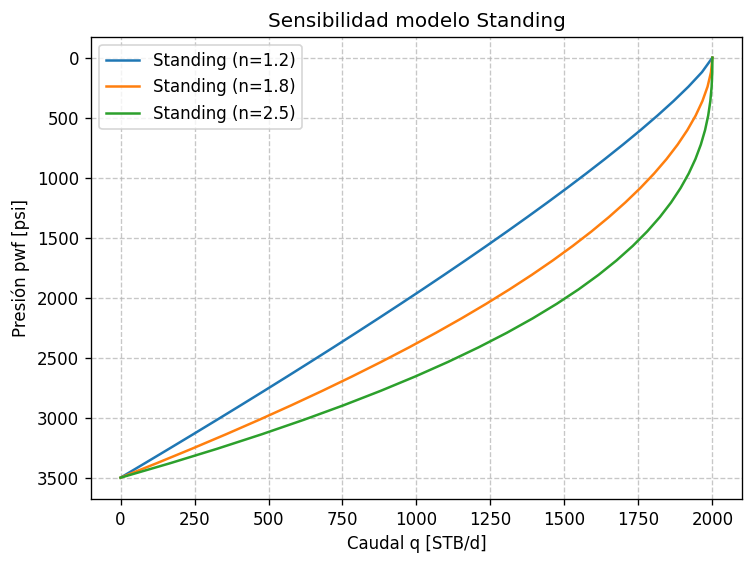

Graficando Sensibilidad de Jones (Skin):


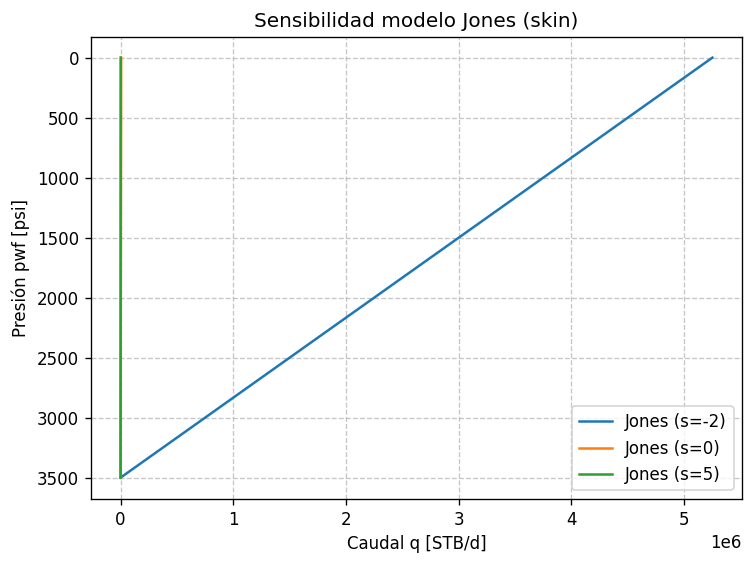

In [5]:
p_res = 3500
q_max = 2000
J = 1.5

print("Graficando Sensibilidad de Standing (n):")
plot_standing_sensitivity(p_res, q_max, n_values=[1.2, 1.8, 2.5])

print("Graficando Sensibilidad de Jones (Skin):")
plot_jones_sensitivity(p_res, J, s_values=[-2, 0, 5])

### 6. Validación de VLP (Modelos Multifásicos)

Utilizamos los modelos robustos de `vlp_advanced` para comparar Beggs & Brill y Hagedorn & Brown.

In [6]:
q_liq = 800
q_gas = 300
d = 2.875
L = 6000
angle = 90
rho_l = 58; rho_g = 0.07
mu_l = 1.2; mu_g = 0.018

dp_bb, h_bb = beggs_brill_dp(q_liq, q_gas, d, L, angle, rho_l, rho_g, mu_l, mu_g)
dp_hb, h_hb = hagedorn_brown_dp(q_liq, q_gas, d, L, rho_l, rho_g, mu_l, mu_g, angle)

print(f"Beggs & Brill (ΔP): {dp_bb:.2f} psi, Holdup: {h_bb:.3f}")
print(f"Hagedorn & Brown (ΔP): {dp_hb:.2f} psi, Holdup: {h_hb:.3f}")

Beggs & Brill (ΔP): 591.18 psi, Holdup: 0.018
Hagedorn & Brown (ΔP): 551.28 psi, Holdup: 0.017


Flowline → ΔP monótona (no decreciente): True


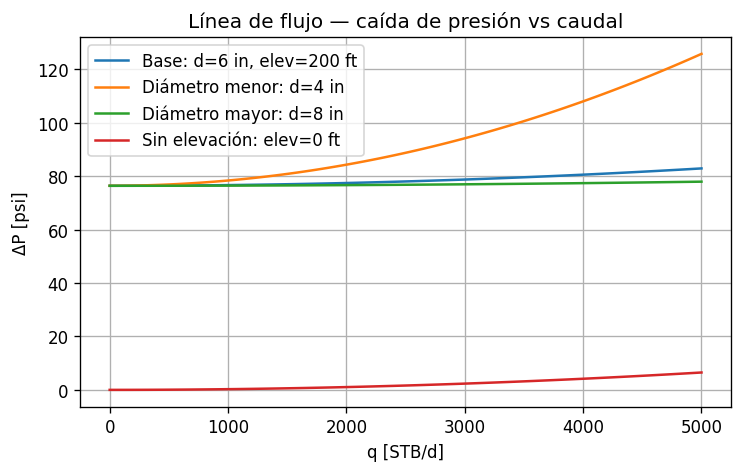

In [7]:
# --- Flowline (superficie): ΔP vs q y efectos de diámetro/elevación ---

q_test = np.linspace(0.0, 5000.0, 80)

L = 10000.0   # ft
rho_fl = 55.0 # lbm/ft3
mu_fl = 1.0   # cP
elev = 200.0  # ft (elevación positiva = subida)

# Caso base
dp_base = np.array(
    [flowline_pressure_drop(q, L=L, d=6.0, rho=rho_fl, mu=mu_fl, f=0.02, elev=elev) for q in q_test],
    dtype=float,
)

# Efecto del diámetro
dp_d_small = np.array(
    [flowline_pressure_drop(q, L=L, d=4.0, rho=rho_fl, mu=mu_fl, f=0.02, elev=elev) for q in q_test],
    dtype=float,
)
dp_d_large = np.array(
    [flowline_pressure_drop(q, L=L, d=8.0, rho=rho_fl, mu=mu_fl, f=0.02, elev=elev) for q in q_test],
    dtype=float,
)

# Efecto de elevación
dp_elev0 = np.array(
    [flowline_pressure_drop(q, L=L, d=6.0, rho=rho_fl, mu=mu_fl, f=0.02, elev=0.0) for q in q_test],
    dtype=float,
)

# Chequeos físicos mínimos
assert np.all(dp_base >= -1e-9), "ΔP no debería ser negativa en este planteamiento"
print("Flowline → ΔP monótona (no decreciente):", np.all(np.diff(dp_base) >= -1e-6))

# Gráficas
plt.figure(figsize=(7, 4))
plt.plot(q_test, dp_base, label="Base: d=6 in, elev=200 ft")
plt.plot(q_test, dp_d_small, label="Diámetro menor: d=4 in")
plt.plot(q_test, dp_d_large, label="Diámetro mayor: d=8 in")
plt.plot(q_test, dp_elev0, label="Sin elevación: elev=0 ft")
plt.xlabel("q [STB/d]")
plt.ylabel("ΔP [psi]")
plt.title("Línea de flujo — caída de presión vs caudal")
plt.grid(True)
plt.legend()
plt.show()



### 7. Análisis nodal — intersección robusta

En lugar de depender de una simple interpolación, se implementa un método robusto de búsqueda de raíces que minimiza $|IPR(q) - VLP(q)|$ sobre $q$ (directamente en el espacio de caudales).

Esto evita artefactos de interpolación cuando la IPR y la VLP están definidas en ejes diferentes.


Q_op (PetroKit) = 757.43 STB/d, pwf_op = 2677.75 psi


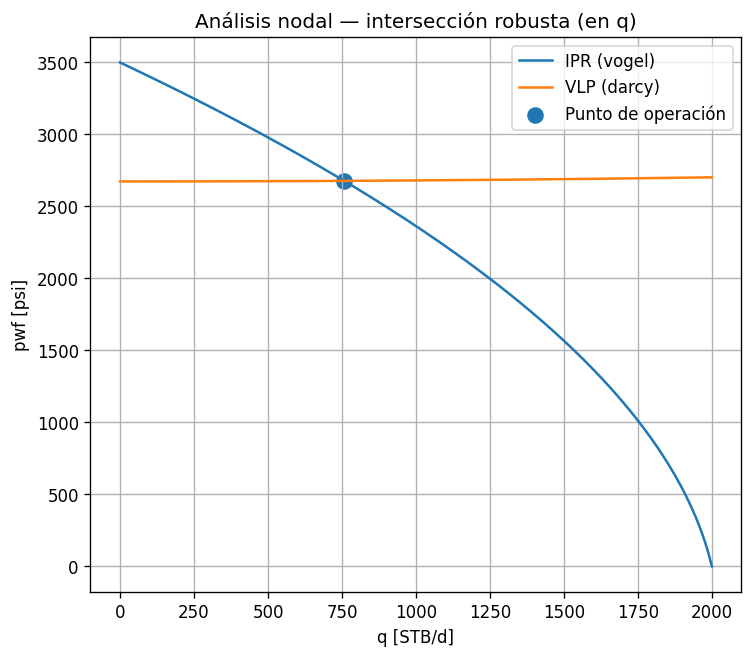

Q_op (SciPy)    = 757.43 STB/d, pwf_op = 2677.75 psi


In [11]:
# --- Sección: Análisis nodal — intersección robusta (alineado con PetroKit Fase 2) ---
import numpy as np
import matplotlib.pyplot as plt
well_depth = 7000.0
if _PETROKIT_AVAILABLE:
    import petrokit as pk

    # ---------- helpers: tomar parámetros si ya existen; si no, poner defaults con aviso ----------
    def _get_param(name, default, aliases=()):
        if name in globals():
            return globals()[name], name, False
        for a in aliases:
            if a in globals():
                globals()[name] = globals()[a]
                return globals()[name], a, False
        globals()[name] = default
        return default, "<default>", True

    p_res, src_p_res, dflt_p_res = _get_param("p_res", 3000.0, aliases=("pres", "p_reservorio", "p_reservoir"))
    q_max, src_qmax, dflt_qmax = _get_param("q_max", 1200.0, aliases=("qmax", "qmax_stb_d"))

    well_depth, src_wd, dflt_wd = _get_param(
        "well_depth", 8000.0, aliases=("well_depth_ft", "depth_ft", "depth", "md_ft", "profundidad", "profundidad_pozo")
    )
    rho, src_rho, dflt_rho = _get_param(
        "rho", 55.0, aliases=("rho_fl", "rho_liq", "density", "dens", "densidad")
    )
    mu, src_mu, dflt_mu = _get_param(
        "mu", 1.0, aliases=("mu_fl", "mu_liq", "visc", "viscosidad")
    )
    d, src_d, dflt_d = _get_param("d", 3.5, aliases=("diameter", "diametro", "diametro_in"))

    if any([dflt_p_res, dflt_qmax, dflt_wd, dflt_rho, dflt_mu, dflt_d]):
        print("⚠️  Usando valores por defecto para variables faltantes:")
        if dflt_p_res: print(f"  - p_res = {p_res}  (psi)")
        if dflt_qmax: print(f"  - q_max = {q_max}  (STB/d)")
        if dflt_wd:   print(f"  - well_depth = {well_depth}  (ft)")
        if dflt_rho:  print(f"  - rho = {rho}  (lbm/ft3)")
        if dflt_mu:   print(f"  - mu = {mu}  (cP)")
        if dflt_d:    print(f"  - d = {d}  (in)")
        print("   (Si ya tienes una celda de parámetros, ejecútala antes para usar tus valores reales.)")

    # ---------- 1) Punto de operación (malla común en q + cambio de signo + interpolación) ----------
    res = pk.nodal_analysis_detail(
        p_res=float(p_res),
        q_max=float(q_max),
        well_depth=float(well_depth),
        rho=float(rho),
        mu=float(mu),
        d=float(d),
        npts=250,
        ipr_model="vogel",
        vlp_model="darcy",  # cambia a "beggs_brill" o "hagedorn_brown" si aplica
    )
    print(f"Q_op (PetroKit) = {res.q_op:.2f} STB/d, pwf_op = {res.pwf_op:.2f} psi")

    # ---------- 2) Gráfica (ambas curvas en el MISMO eje q_grid) ----------
    plt.figure(figsize=(7, 6))
    plt.plot(res.q_grid, res.pwf_ipr_on_q, label=f"IPR ({res.ipr_model})")
    plt.plot(res.q_grid, res.pwf_vlp_on_q, label=f"VLP ({res.vlp_model})")
    plt.scatter([res.q_op], [res.pwf_op], s=80, label="Punto de operación")
    plt.xlabel("q [STB/d]")
    plt.ylabel("pwf [psi]")
    plt.title("Análisis nodal — intersección robusta (en q)")
    plt.grid(True)
    plt.legend()
    plt.show()

    # ---------- 3) Validación opcional con SciPy: minimizar |IPR(q) - VLP(q)| en q ----------
    try:
        from scipy.optimize import minimize_scalar
        _SCIPY = True
    except Exception:
        _SCIPY = False

    if _SCIPY:
        q_lo, q_hi = float(res.q_grid[0]), float(res.q_grid[-1])

        def pwf_ipr(q): return float(np.interp(q, res.q_grid, res.pwf_ipr_on_q))
        def pwf_vlp(q): return float(np.interp(q, res.q_grid, res.pwf_vlp_on_q))
        def objective(q): return abs(pwf_ipr(q) - pwf_vlp(q))

        opt = minimize_scalar(objective, bounds=(q_lo, q_hi), method="bounded")
        if opt.success:
            q_op_opt = float(opt.x)
            pwf_op_opt = pwf_vlp(q_op_opt)
            print(f"Q_op (SciPy)    = {q_op_opt:.2f} STB/d, pwf_op = {pwf_op_opt:.2f} psi")
        else:
            print("⚠️  SciPy no encontró óptimo (res.success=False). Se mantiene el resultado de PetroKit.")
else:
    print("Omitiendo análisis nodal — petrokit no disponible")



### 8. Estudios de sensibilidad y barridos paramétricos

Ejecutamos un conjunto de barridos paramétricos para ilustrar el efecto de:

* El diámetro de la tubería
* La presión de yacimiento `p_res`
* La densidad del fluido

Los resultados se organizan en salidas tabulares y gráficos de resumen.


In [ ]:
if _PETROKIT_AVAILABLE:
    diameters = [2.992, 3.5, 4.5, 6.0]  # pulgadas
    p_res_values = [2500, 3000, 3500]
    results = []

    for d_test in diameters:
        q_op_list = []
        for pres in p_res_values:
            try:
                qop, pwfop = find_q_op(pres, q_max, well_depth, rho, mu, d_test)
            except Exception:
                qop, pwfop = np.nan, np.nan
            q_op_list.append(qop)
        results.append(q_op_list)

    # Gráfico de resultados
    plt.figure(figsize=(7,5))
    for idx, d_test in enumerate(diameters):
        plt.plot(p_res_values, results[idx], marker='o', label=f'D={d_test}\"')
    plt.xlabel('p_res [psi]')
    plt.ylabel('Q_op [STB/d]')
    plt.title('Sensibilidad: Q_op vs p_res para diferentes diámetros de tubería')
    plt.grid(True)
    plt.legend()
    plt.show()
else:
    print('Omitiendo estudios de sensibilidad — petrokit no disponible')



### 9. Exportación de resultados y figuras

Guardamos la tabla de resumen y exportamos la figura principal para su uso en informes.


In [16]:
# --- Exportación de resultados + (fallback) cálculo de sensibilidad si faltan variables ---
from pathlib import Path
import csv
import numpy as np
import matplotlib.pyplot as plt

if _PETROKIT_AVAILABLE:
    import petrokit as pk

    # ---------- 0) Defaults si no existen diameters / p_res_values ----------
    if "diameters" not in globals():
        diameters = [2.875, 3.5, 4.0]  # in
        print("⚠️  'diameters' no existía. Usando default:", diameters)

    if "p_res_values" not in globals():
        # si ya existe p_res, usa un rango alrededor; si no, define uno razonable
        base = globals().get("p_res", 3000.0)
        p_res_values = [base - 500, base, base + 500]
        print("⚠️  'p_res_values' no existía. Usando default:", p_res_values)

    # ---------- 1) Verifica/crea results ----------
    need_results = ("results" not in globals())
    if not need_results:
        try:
            # valida forma esperada: results[i][j]
            _ = results[0][0]
            # valida tamaño aproximado
            if len(results) != len(diameters) or len(results[0]) != len(p_res_values):
                need_results = True
        except Exception:
            need_results = True

    if need_results:
        # Necesitamos también los parámetros base para correr nodal
        required_params = ["q_max", "well_depth", "rho", "mu"]
        missing = [k for k in required_params if k not in globals()]
        if missing:
            raise NameError(
                "No puedo calcular 'results' porque faltan parámetros base: "
                + ", ".join(missing)
                + ". Define esos parámetros o ejecuta la celda de parámetros."
            )

        # d (diámetro) lo variamos en diameters, así que aquí usamos placeholder
        print("ℹCalculando 'results' con PetroKit para la sensibilidad...")

        results = []
        for d_test in diameters:
            row = []
            for pres in p_res_values:
                r = pk.nodal_analysis_detail(
                    p_res=float(pres),
                    q_max=float(q_max),
                    well_depth=float(well_depth),
                    rho=float(rho),
                    mu=float(mu),
                    d=float(d_test),
                    npts=250,
                    ipr_model="vogel",
                    vlp_model="darcy",
                )
                row.append(r)  # guardamos el objeto completo (q_op y pwf_op)
            results.append(row)

    # ---------- 2) Exporta CSV ----------
    out_dir = Path("output")
    out_dir.mkdir(exist_ok=True)
    summary_csv = out_dir / "nodal_summary.csv"

    with open(summary_csv, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["diametro_in", "p_res", "q_op_stb_d", "pwf_psi"])

        for i, d_test in enumerate(diameters):
            for j, pres in enumerate(p_res_values):
                r = results[i][j]
                q_op = getattr(r, "q_op", "")
                pwf_op = getattr(r, "pwf_op", "")
                writer.writerow([d_test, pres, q_op, pwf_op])

    print("Resumen guardado en", summary_csv)

    # ---------- 3) Guarda figura si existe ----------
    fig_path = out_dir / "nodal_sensitivity.png"
    try:
        fig = plt.gcf()
        if fig.axes:  # solo si tiene ejes (algo dibujado)
            fig.savefig(fig_path, bbox_inches="tight", dpi=150)
            print("Figura guardada en", fig_path)
        else:
            print("ℹNo se guardó figura: no hay gráfico activo.")
    except Exception as e:
        print("ℹNo se pudo guardar la figura. Detalle:", e)

else:
    print("Omitiendo exportación — petrokit no disponible")



⚠️  'diameters' no existía. Usando default: [2.875, 3.5, 4.0]
⚠️  'p_res_values' no existía. Usando default: [3000, 3500, 4000]
ℹCalculando 'results' con PetroKit para la sensibilidad...
Resumen guardado en output\nodal_summary.csv
ℹNo se guardó figura: no hay gráfico activo.


<Figure size 768x576 with 0 Axes>

---

## Apéndice: Referencias y lecturas adicionales

* Vogel, J. R. (1968). *“Electrostatic phenomena in petroleum production”* (referencia clásica de IPR).
* Beggs, Hagedorn & Brown — correlaciones para flujo multifásico en pozos y tuberías.
* White, F. M. — *Mecánica de Fluidos* (fundamentos de Darcy–Weisbach).

---

Fin del cuaderno.
